## Python-gmt Test with FSU/NOAA Ship Data from ERDDAP


__pyversion__==3.6   
__author__==S.Bell

In [1]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url='https://coastwatch.pfeg.noaa.gov/erddap'
e = ERDDAP(server=server_url)

Get only Ship NRT datafiles   
-NRT files exist back to the start of the year   
-qc files exist back to 2007?

In [2]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='fsu nrt'))

In [3]:
boats = df['Dataset ID'].values
print(boats)

['fsuNoaaShipWTDLnrt' 'fsuNoaaShipWTEBnrt' 'fsuNoaaShipWTEYnrt'
 'fsuNoaaShipWTDOnrt' 'fsuNoaaShipWTEPnrt' 'fsuNoaaShipWTEFnrt'
 'fsuNoaaShipWTEDnrt' 'fsuNoaaShipWTEOnrt' 'fsuNoaaShipWTDFnrt'
 'fsuNoaaShipWTERnrt' 'fsuNoaaShipWTDHnrt' 'fsuNoaaShipWTEGnrt'
 'fsuNoaaShipWTECnrt' 'fsuNoaaShipWTEKnrt' 'fsuNoaaShipWTEEnrt'
 'fsuResearchShipKAQPnrt' 'fsuResearchShipWECBnrt'
 'fsuResearchShipWKWBnrt' 'fsuResearchShipZMFRnrt'
 'fsuResearchShipWDA7827nrt' 'fsuResearchShipKAOUnrt'
 'fsuResearchShipKTDQnrt' 'fsuResearchShipWDC9417nrt'
 'fsuResearchShipWCX7445nrt' 'fsuResearchShipWBP3210nrt'
 'fsuResearchShipWSQ2674nrt']


In [16]:
kw = {
    'min_lon': 0,
    'max_lon': 540,
    'min_lat': 0.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': str(datetime.datetime.now()),
    'cdm_data_type': 'trajectory'
}

In [17]:
variables = [e.get_var_by_attr(dataset_id=ship, 
                               long_name=lambda v: v is not None) for ship in boats]
#print(variables)

In [18]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.remove('flag') 
common_variables.add('seaTemperature')
common_variables

{'airPressure',
 'latitude',
 'longitude',
 'platformCourse',
 'platformHeading',
 'platformSpeed',
 'seaTemperature',
 'time'}

In [19]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

In [20]:
from requests.exceptions import HTTPError

dfs = {}
for boat in boats:
    print(boat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=boat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({boat: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

fsuNoaaShipWTDLnrt
fsuNoaaShipWTEBnrt
fsuNoaaShipWTEYnrt
fsuNoaaShipWTDOnrt
fsuNoaaShipWTEPnrt
fsuNoaaShipWTEFnrt
fsuNoaaShipWTEDnrt
fsuNoaaShipWTEOnrt
fsuNoaaShipWTDFnrt
fsuNoaaShipWTERnrt
fsuNoaaShipWTDHnrt
fsuNoaaShipWTEGnrt
fsuNoaaShipWTECnrt
fsuNoaaShipWTEKnrt
fsuNoaaShipWTEEnrt
fsuResearchShipKAQPnrt
fsuResearchShipWECBnrt
fsuResearchShipWKWBnrt
fsuResearchShipZMFRnrt
fsuResearchShipWDA7827nrt
fsuResearchShipKAOUnrt
fsuResearchShipKTDQnrt
fsuResearchShipWDC9417nrt
fsuResearchShipWCX7445nrt
fsuResearchShipWBP3210nrt
fsuResearchShipWSQ2674nrt


fsuNoaaShipWTDLnrt
fsuNoaaShipWTEBnrt
fsuNoaaShipWTEYnrt
fsuNoaaShipWTDOnrt
fsuNoaaShipWTEPnrt
fsuNoaaShipWTEFnrt
fsuNoaaShipWTEDnrt
fsuNoaaShipWTEOnrt
fsuNoaaShipWTDFnrt
fsuNoaaShipWTERnrt
fsuNoaaShipWTDHnrt
fsuNoaaShipWTEGnrt
fsuNoaaShipWTECnrt
fsuNoaaShipWTEEnrt
fsuResearchShipZMFRnrt
fsuResearchShipKAOUnrt
fsuResearchShipKTDQnrt
fsuResearchShipWSQ2674nrt


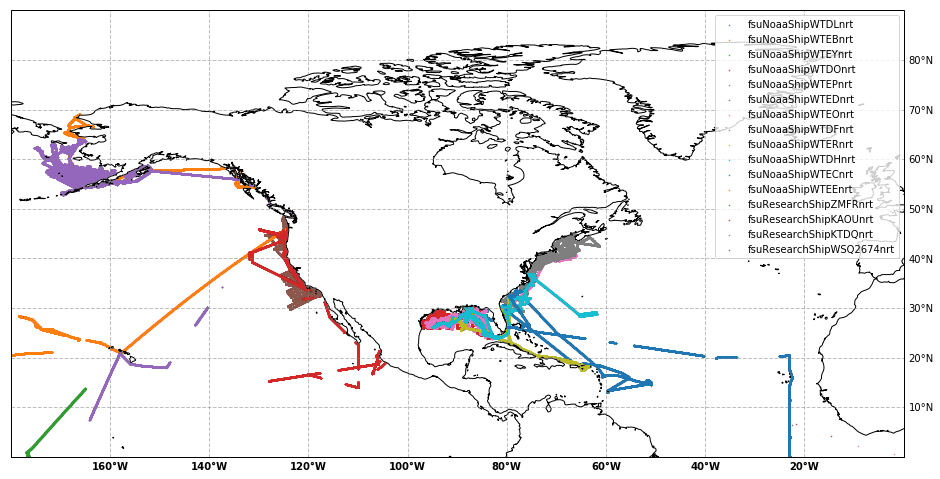

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 16),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(linewidth=1, color='gray', 
                          alpha=0.5, linestyle='--',draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 15, 'color': 'gray'}
        gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
#extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, 0, 0, 72]
fig,ax = make_map()
for ship, df in dfs.items():
    print(ship)
    if ('fsu' in ship) and ( ship not in ['fsuNoaaShipWTEGnrt','fsuNoaaShipWTEFnrt']):
    #if ('fsu' in ship) and ( ship in ['fsuNoaaShipWTEPnrt']):
        try:
            ax.scatter(df['longitude'], df['latitude'], s=0.25, label=ship, transform=transformation)
        except:
            print("{ship} cannot be plotted".format(ship=ship))

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)